In [1]:
import sys
sys.path.append('/usr/local/lib/python3.11/site-packages') 
import matplotlib.pylab as plt
from matplotlib.patches import Circle

import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.io.shapereader import Reader
import intake
from easygems.healpix import attach_coords, healpix_show, healpix_contour
import easygems.healpix as egh
import numpy as np
import xarray as xr
import seaborn as sn
import geopy.distance

from matplotlib.colors import LinearSegmentedColormap

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")

In [2]:
era5 = cat.HERA5(time="PT1H").to_dask().pipe(attach_coords)

In [3]:
cwv_crit = 50.0

In [4]:
coordinates = {'mindeloNorth': 16.88, 'mindeloEast': -24.98, 
               'salNorth': 16.74, 'salEast': -22.94, 
               'bcoNorth': 13.15, 'bcoEast': -59.42,
              }

In [5]:
sel_time = "2023-09-08T19:00:00"

# EC orbits

In [6]:
c_earth = 40075.017      # circumference of earth at equator
spd     = 86400.         # seconds per day
kpd     = c_earth/360    # kilometers per degreen longitude at the equator

t_op = 5552.7
t_cv = 5554.3

n_op = 25
n_cv =  9

def offset(n,t):
    # copmute offset in degrees for the n'th orbit
    return (-c_earth * t/86400. * n/kpd)

In [7]:
def calc_orbits(scenario,wb=330.,eb=340.):
 
    if (scenario == 'operations'): 
        ndays = n_op
        t = t_op
    else:
        ndays = n_cv
        t = t_cv
        scenario = 'calval'
    
    orbits = ndays * spd/t
    print (f'Calculations for {scenario}: {orbits:3g} unique orbits\n')

    lons = np.zeros(int(orbits))
    days = np.zeros(int(orbits))
    
    for i, norbit in enumerate(np.arange(0,int(orbits))):
        lons[i] = offset(norbit,t)%360
        days[i] = norbit*t/86400 + 1
    
    lons_sel =[]
    days_sel = []
    for i,lon in enumerate(lons):
        if (lon > wb and lon < eb) : 
            lons_sel.append(lons[i]-360.0);
            days_sel.append(np.round(days[i]));
            
    return lons_sel,days_sel

def calc_track(sing_lon_ec, edge_south, edge_north, lon_band, same_track_back = True, pointReturn = (np.nan, np.nan)):
    
        # Calculates straight legs connecting the circles and the airport
    
    if lon_band == 'east':
        lat_airport, lon_airpot = coordinates['salNorth'], coordinates['salEast']  

    elif lon_band == 'west':
        lat_airport, lon_airpot = coordinates['bcoNorth'], coordinates['bcoEast'] 

    else:
        lat_airport, lon_airpot = np.nan, np.nan
        
    leg_coords_airport = [(lat_airport, lon_airpot)]
    leg_coords_ec = [(edge_north, sing_lon_ec+(edge_north*np.tan(7/180*np.pi))),
                     (edge_south, sing_lon_ec+(edge_south*np.tan(7/180*np.pi))), 
                    ]
    
    track = leg_coords_airport + leg_coords_ec
    
    if same_track_back:
        return track + track[::-1]
    
    else:
        return track + [pointReturn] + leg_coords_airport

In [8]:
leg_coords = [(coordinates['bcoNorth'], coordinates['bcoEast']),
              (10.0, -40.0),
              (0.0, -40.0),
              (coordinates['bcoNorth'], coordinates['bcoEast'])
             ]

leg_coords2 = [(coordinates['bcoNorth'], coordinates['bcoEast']),
              (9.0, -45.0),
              (3.0, -45.0),
              (coordinates['bcoNorth'], coordinates['bcoEast'])
             ]

leg_coords3 = [(coordinates['bcoNorth'], coordinates['bcoEast']),
              (8.0, -45.0),
              (3.0, -45.0),
              (coordinates['bcoNorth'], coordinates['bcoEast'])
             ]

In [9]:
def calc_length_track(leg_coords): 
        
    distanceKm = 0
    for i_coord in range(len(leg_coords)-1):
        distanceKm += geopy.distance.geodesic(leg_coords[i_coord], leg_coords[i_coord+1]).km
        
    return distanceKm

In [10]:
halo_speed_12km_kmh = 225*3.6

In [11]:
ds=xr.open_dataset('itcz_edge_freq_2010-2023_50mm.nc')

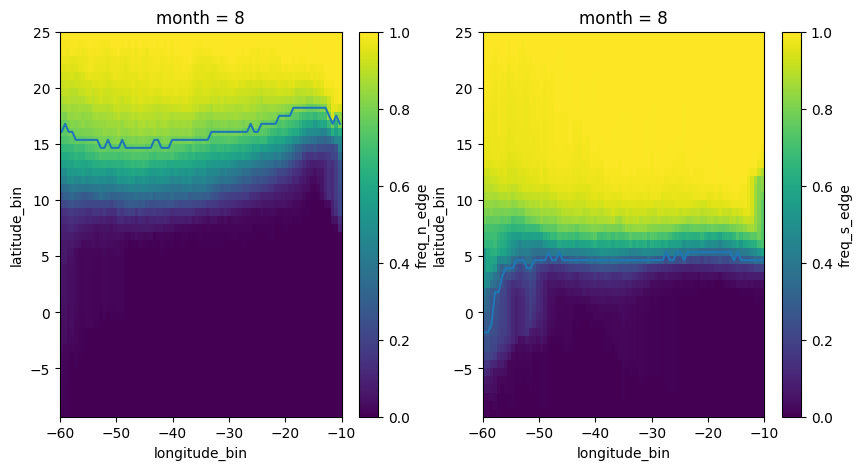

In [16]:
edge_quantile = 0.25

prob_edge_north_lat = (ds.freq_n_edge.sel(month=8).cumsum('latitude_bin')/ds.freq_n_edge.sel(month=8).sum('latitude_bin'))
worst_case_north = prob_edge_north_lat.latitude_bin.where(prob_edge_north_lat>(1.0-edge_quantile)).min('latitude_bin')

prob_edge_south_lat = (ds.freq_s_edge.sel(month=8).cumsum('latitude_bin')/ds.freq_s_edge.sel(month=8).sum('latitude_bin'))
worst_case_south = prob_edge_south_lat.latitude_bin.where(prob_edge_south_lat>(edge_quantile)).min('latitude_bin')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

plt.sca(ax[0])
prob_edge_north_lat.plot(x='longitude_bin')
worst_case_north.plot()

plt.sca(ax[1])
prob_edge_south_lat.plot(x='longitude_bin')
worst_case_south.plot()

In [67]:
x_lat = np.arange(len(flightLat))
x_int = np.arange(x_lat[0], x_lat[-1]+0.1, 0.05)

flightLat_int, flightLon_int = np.interp(x_int, x_lat, flightLat), np.interp(x_int, x_lat, flightLon)

track_s_int = list(zip(flightLat_int, flightLon_int))

time_take_off = np.datetime64(f'2024-08-12T12:00')
time_ec_equator = np.datetime64(f'2024-08-12T14:00')

for coord_i in range(1, len(track_s_int)+1):
    
    length_track_i_km = calc_length_track(track_s_int[:coord_i])
    duration_track_i_h = length_track_i_km/halo_speed_12km_kmh + 0.5
    duration_track_i_m = np.timedelta64(int(duration_track_i_h*60), 'm')
    
    if duration_track_i_m > (time_ec_equator - time_take_off):
        print(time_take_off + duration_track_i_m)
        
        track_to_ec = track_s_int[:coord_i-1]
        
        break

2024-08-12T14:03


In [41]:
time_take_off = np.datetime64(f'2024-08-12T12:00')
time_ec_equator = np.datetime64(f'2024-08-12T14:00')

for coord_i in range(1, len(track_s)+1):
    
    length_track_i_km = calc_length_track(track_s[:coord_i])
    duration_track_i_h = length_track_i_km/halo_speed_12km_kmh + 0.5
    
    print(time_take_off + np.timedelta64(int(duration_track_i_h*60), 'm'))

2024-08-12T12:30
2024-08-12T12:59
2024-08-12T14:55
2024-08-12T14:55
2024-08-12T16:50
2024-08-12T17:20


In [80]:
def find_subtrack(flightLat, flightLon):
    x_lat = np.arange(len(flightLat))
    x_int = np.arange(x_lat[0], x_lat[-1]+0.1, 0.05)

    flightLat_int, flightLon_int = np.interp(x_int, x_lat, flightLat), np.interp(x_int, x_lat, flightLon)

    track_s_int = list(zip(flightLat_int, flightLon_int))

    time_take_off = np.datetime64(f'2024-08-12T12:00')
    time_ec_equator = np.datetime64(f'2024-08-12T14:00')

    for coord_i in range(1, len(track_s_int)+1):

        length_track_i_km = calc_length_track(track_s_int[:coord_i])
        duration_track_i_h = length_track_i_km/halo_speed_12km_kmh + 0.5
        duration_track_i_m = np.timedelta64(int(duration_track_i_h*60), 'm')

        if duration_track_i_m > (time_ec_equator - time_take_off):
            print(time_take_off + duration_track_i_m)

            return track_s_int[:coord_i-1]

find_subtrack(flightLat, flightLon);

2024-08-12T14:03


Calculations for operations: 389 unique orbits

Calculations for operations: 389 unique orbits

east
(1) EC long. at equator: -30.54, estimated flight duration: 9.30 h
2024-08-12T14:05
(2) EC long. at equator: -29.61, estimated flight duration: 9.06 h
2024-08-12T14:04
(3) EC long. at equator: -28.69, estimated flight duration: 8.82 h
2024-08-12T14:02
(4) EC long. at equator: -27.76, estimated flight duration: 8.58 h
2024-08-12T14:01
(5) EC long. at equator: -26.84, estimated flight duration: 8.33 h
2024-08-12T14:05
(6) EC long. at equator: -25.91, estimated flight duration: 8.10 h
2024-08-12T14:03
(7) EC long. at equator: -24.99, estimated flight duration: 7.92 h
2024-08-12T14:04
(8) EC long. at equator: -24.06, estimated flight duration: 8.12 h
2024-08-12T14:04
(9) EC long. at equator: -23.14, estimated flight duration: 8.35 h
2024-08-12T14:05
(10) EC long. at equator: -22.21, estimated flight duration: 8.60 h
2024-08-12T14:01
(11) EC long. at equator: -21.29, estimated flight duratio

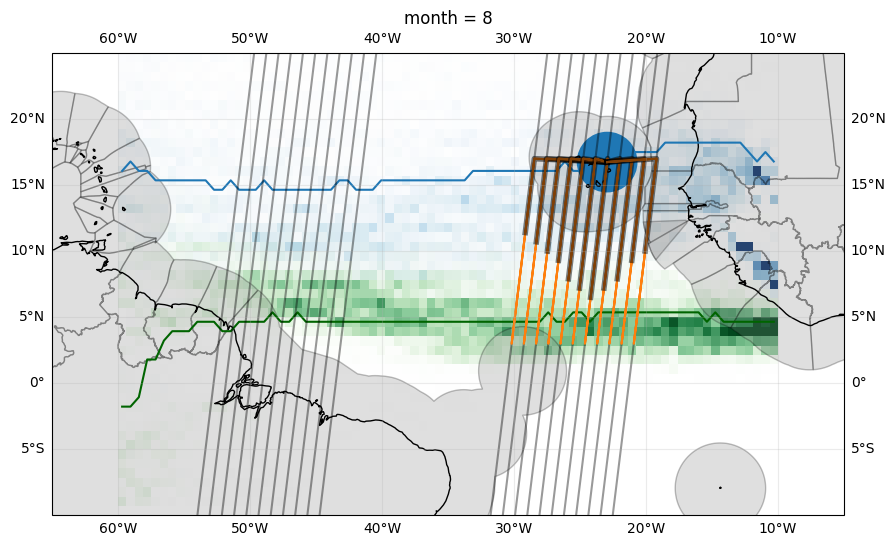

In [98]:
levels_cwv = np.sort(np.unique([cwv_crit, 45, 50, 55]))

plt.figure(figsize = (12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-65, -5, -10, 25], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

#Add the shapefiles
direc_shp, file_shp = '../TrackPlanning/EEZ_land_union_v3_202003/', 'EEZ_Land_v3_202030.shp'
shape_feature = cpf.ShapelyFeature(Reader(direc_shp+file_shp).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='grey', alpha = 0.25)
ax.add_feature(shape_feature,zorder=1)

##Adds EC orbits

ec_tracks = {'east': {'wb': -31+360.0, 'eb': -21+360.0, 'date_start': '2024-08-12'},
             'west': {'wb': -53+360.0, 'eb': -43+360.0, 'date_start': '2024-09-12'},
            }

for region in ['east', 'west']:
    
    lon_ec,time_ec = calc_orbits('operations',wb=ec_tracks[region]['wb'],eb=ec_tracks[region]['eb'])
    time_ec = np.array(time_ec+np.datetime64(ec_tracks[region]['date_start'],'D').astype(int), dtype='datetime64[D]')
    lat_ec = np.zeros(len(lon_ec))
    
    ec_tracks[region]['lon_ec'] = lon_ec
    ec_tracks[region]['lat_ec'] = lat_ec

ec_lat_max = 25

## Adds southern and northern edge frequency
cm_north = LinearSegmentedColormap.from_list("north", colors=[plt.get_cmap("Blues")(i)[:3] + (i/255,) for i in range(plt.get_cmap("Reds").N)])
cm_south = LinearSegmentedColormap.from_list("south", colors=[plt.get_cmap("Greens")(i)[:3] + (i/255,) for i in range(plt.get_cmap("Blues").N)])
map_extent = [-65, -5, -10, 25]

month_sel = 9

ds.freq_n_edge.sel(month=month_sel).plot.imshow(x="longitude_bin",y='latitude_bin', vmax=0.015, cmap=cm_north, add_colorbar=False, extent=[-60, -10, -10, 25], transform=ccrs.PlateCarree())
ds.freq_s_edge.sel(month=month_sel).plot.imshow(x="longitude_bin",y='latitude_bin', vmax=0.015, cmap=cm_south, add_colorbar=False, extent=[-60, -10, -10, 25],transform=ccrs.PlateCarree())

worst_case_north.plot(color = 'C0')
worst_case_south.plot(color = 'darkgreen')
    
circle_sal = Circle((coordinates['salEast'], coordinates['salNorth']), radius=2.3)
ax.add_patch(circle_sal)

ec_lat_min = -10

for region in ['east', 'west']:
    lon_ec = ec_tracks[region]['lon_ec']
    for i in range(len(lon_ec)):
        plt.plot([lon_ec[i]+(ec_lat_min*np.tan(7/180*np.pi)),lon_ec[i]+(ec_lat_max*np.tan(7/180*np.pi))],
                 [ec_lat_min,ec_lat_max], color = 'k', alpha=0.4)

number_circles = 3
duration_circle_h = 1

extra_time_landing_takeoff_h = 1.0

lat_regions = {'east': {'north': 17, 'south': 3}, 'west': {'north': coordinates['bcoNorth'], 'south': 5}}

pointReturnNorth, pointReturnEast = lat_regions['west']['north'], ec_tracks['west']['wb']-360.0

same_track_switch = {'east': True, 'west': False}

for region in ['east']:
    print(region)
    lon_ec = ec_tracks[region]['lon_ec']
    lat_min, lat_max = lat_regions[region]['south'], lat_regions[region]['north']
    
    for i_ec, sing_lon_ec in enumerate(np.sort(lon_ec)):
        
        track_s = calc_track(sing_lon_ec, lat_min, lat_max, region, same_track_back=same_track_switch[region], pointReturn=(pointReturnNorth, pointReturnEast))

        track_length_km = calc_length_track(track_s)
        duration_h = (track_length_km/halo_speed_12km_kmh) + number_circles*duration_circle_h + extra_time_landing_takeoff_h

        flightLat, flightLon  = zip(*track_s)
        plt.plot(flightLon, flightLat, c = 'C1')
        #print(f"{sing_lon_ec:.2f}, {duration_h:.2f} h {flightLat, flightLon}")
        print(f"({i_ec+1}) EC long. at equator: {sing_lon_ec:.2f}, estimated flight duration: {duration_h:.2f} h")    
        
        ec_subtrack = find_subtrack(flightLat, flightLon)
        flightLat_sub, flightLon_sub  = zip(*ec_subtrack)
        plt.plot(flightLon_sub, flightLat_sub, c = 'k', linewidth = 4, alpha = 0.5)

In [90]:
(coordinates['salNorth'], coordinates['salEast'])

(16.74, -22.94)

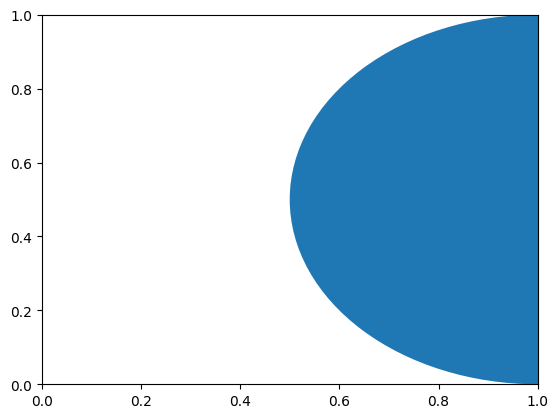

In [96]:
fig, ax = plt.subplots(1, 1)
circle_sal = Circle((1, 0.5), radius=0.5)
ax.add_patch(circle_sal)
plt.show()

In [14]:
import re

def dms_to_decimal(degrees, minutes, seconds, direction):
    decimal = float(degrees) + float(minutes) / 60 + float(seconds) / 3600
    if direction in ['S', 'W']:
        decimal = -decimal
    return decimal

def parse_coordinates(file_path):
    coordinates_dict = {}
    current_key = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            if line and not line.startswith('U'):
                current_key = line
                coordinates_dict[current_key] = []
            elif line:
                coordinates_match = re.findall(r'(\d+)° (\d+)[\' ](\d+\.\d+)" ([NSWE])', line)
                if coordinates_match:
                    degrees, minutes, seconds, direction = coordinates_match[0]
                    decimal_coordinates = dms_to_decimal(degrees, minutes, seconds, direction)
                    coordinates_dict[current_key].append(decimal_coordinates)

    return coordinates_dict

file_path = 'waypoint_coordinates_short.txt'
result = parse_coordinates(file_path)

for key, value in result.items():
    print(f"{key}: {value}")

GUNET 19° 35' 42.00" N 019° 44' 06.00" W: []
DELAX 08° 20' 12.00" N 026° 03' 06.00" W: []
ERETU 03 07.70N 028 48.00W: []
PUGUN 00° 13' 44.40" N 030° 18' 42.00" W: []
NEURA 00 56.18S 030 54.85W: []
AMBET 07 45.57S 034 26.74W: []
MEDIT 11 07.69S 036 14.19W: []
ESLIB 13° 05' 13.20" S 037° 16' 13.20" W: []
BIDEV 16 14.03S 038 58.34W: []
VUKIR 01 55.83S 029 58.78W: []
MOXIP 05 47.80S 031 56.77W: []
ROSTA 28° 15' 21.82" N 020° 00' 00.00" W: []
EDUMO 22° 55' 00.00" N 023° 36' 00.00" W: []
GAMBA 18° 57' 12.00" N 026° 03' 36.00" W: []
SAGRO 10° 35' 00.00" N 030° 51' 48.00" W: []
NANIK 06 20.50N 033 10.34W: []
DIKEB 04 29.87N 034 09.29W: []
CARVE 02 41.96N 035 06.96W: []
JOBER 00 56.79S 037 02.88W: []
ROLID 03 31.95S 038 10.97W: []
BUVUK 05° 30' 00.00" N 025° 50' 00.00" W: []
ASEBA 07° 18' 39.52" N 028° 13' 08.00" W: []
BUXON 08° 29' 02.42" N 029° 46' 58.71" W: []
POKSI 11° 51' 03.86" N 034° 23' 02.03" W: []
IRELA 14° 00' 00.00" N 037° 26' 00.00" W: []


In [15]:
result

{'GUNET 19° 35\' 42.00" N 019° 44\' 06.00" W': [],
 'DELAX 08° 20\' 12.00" N 026° 03\' 06.00" W': [],
 'ERETU 03 07.70N 028 48.00W': [],
 'PUGUN 00° 13\' 44.40" N 030° 18\' 42.00" W': [],
 'NEURA 00 56.18S 030 54.85W': [],
 'AMBET 07 45.57S 034 26.74W': [],
 'MEDIT 11 07.69S 036 14.19W': [],
 'ESLIB 13° 05\' 13.20" S 037° 16\' 13.20" W': [],
 'BIDEV 16 14.03S 038 58.34W': [],
 'VUKIR 01 55.83S 029 58.78W': [],
 'MOXIP 05 47.80S 031 56.77W': [],
 'ROSTA 28° 15\' 21.82" N 020° 00\' 00.00" W': [],
 'EDUMO 22° 55\' 00.00" N 023° 36\' 00.00" W': [],
 'GAMBA 18° 57\' 12.00" N 026° 03\' 36.00" W': [],
 'SAGRO 10° 35\' 00.00" N 030° 51\' 48.00" W': [],
 'NANIK 06 20.50N 033 10.34W': [],
 'DIKEB 04 29.87N 034 09.29W': [],
 'CARVE 02 41.96N 035 06.96W': [],
 'JOBER 00 56.79S 037 02.88W': [],
 'ROLID 03 31.95S 038 10.97W': [],
 'BUVUK 05° 30\' 00.00" N 025° 50\' 00.00" W': [],
 'ASEBA 07° 18\' 39.52" N 028° 13\' 08.00" W': [],
 'BUXON 08° 29\' 02.42" N 029° 46\' 58.71" W': [],
 'POKSI 11° 51\' 03